# WiFi Ensembles Tutorial: Frequentist Uncertainties for Neural Density Ratio Estimation

This notebook demonstrates the core concepts of $w_i f_i$ ensembles for estimating density ratios with asymptotic frequentist uncertainties, as presented in [the paper](https://arxiv.org/abs/2506.00113). We'll work with a simple 1D example that runs quickly on a laptop (the Gaussian example from the paper on a smaller dataset).

## What are $w_i f_i$ Ensembles?

$w_i f_i$ ensembles provide a way to estimate density ratios and uncertainty on those density ratios by:
1. Training multiple neural networks (ensemble members) $f_i(x)$ as basis functions
2. Finding optimal linear combination weights $w_i$ using a symmetrized MLC loss
3. Computing asymptotic covariance matrices for the weights $w_i$
4. (Optional) Using the Gong-Samaniego theorem to propagate weight uncertainties to downstream parameter estimates

## Symmetrized MLC Loss

To fit the $w_i$, we use the symmetrized MLC loss which respects the symmetry under $n \leftrightarrow d$ and $w_i f_i \rightarrow -w_i f_i$:

**For signal samples (n)**: $\mathcal{L}_n = - w_i f_i(x) + (e^{-w_i f_i(x)} - 1)$
**For background samples (d)**: $\mathcal{L}_d = w_i f_i(x) + (e^{w_i f_i(x)} - 1)$

This loss is used both for:
- **Training individual ensemble members** $f_i(x)$ 
- **Optimizing ensemble weights** $w_i$ after training

## Problem Setup

We want to estimate the density ratio using datasets with samples from $n$ and $d$, which are respectively Gaussians with unit variance and mean $\pm 0.1$, and then the mixture fraction $\kappa$ from a dataset drawn from a mixture model of samples from $n$ with probability $\kappa$ and samples from $d$ with probability $1-\kappa$.

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from torchmin import minimize

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

num_train_samples = 5000
num_test_samples = 5000
num_ensemble_members = 16
hidden_units = 32
epochs = 150
batch_size = 200

Using device: cpu


## Generate Synthetic Data

Let's create simple 1D Gaussian distributions for our signal and background.

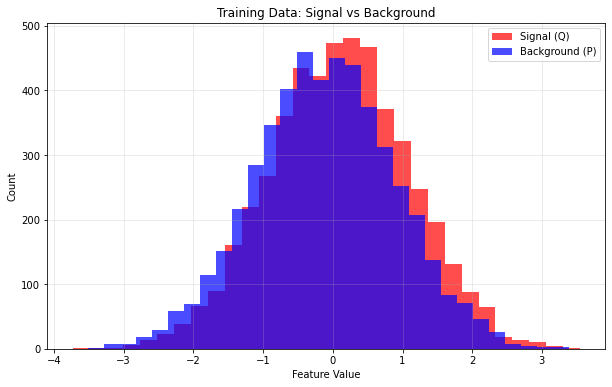

Generated 5000 training samples
Signal samples: 5000
Background samples: 5000


In [23]:
def generate_data(n_samples, signal_mean=0.1, background_mean=-0.1, noise_std=1.0):
    """Generate training data with signal and background samples."""
    # Signal samples (label = 1)
    signal_data = torch.randn(n_samples) * noise_std + signal_mean
    signal_labels = torch.ones(n_samples)
    
    # Background samples (label = 0)
    background_data = torch.randn(n_samples) * noise_std + background_mean
    background_labels = torch.zeros(n_samples)
    
    # Combine and shuffle
    data = torch.cat([signal_data, background_data]).unsqueeze(1)
    labels = torch.cat([signal_labels, background_labels])
    
    # Shuffle
    perm = torch.randperm(2*n_samples)
    return data[perm], labels[perm]

def generate_mixture(n_samples, true_fraction, signal_mean=0.1, background_mean=-0.1, noise_std=1.0):
    """Generate a test mixture with known fraction of signal samples."""
    signal_mask = torch.rand(n_samples) < true_fraction
    background_mask = ~signal_mask
    n_signal = signal_mask.sum().item()
    n_background = background_mask.sum().item()
    
    signal_data = torch.randn(n_signal) * noise_std + signal_mean
    background_data = torch.randn(n_background) * noise_std + background_mean
    
    mixture_data = torch.cat([signal_data, background_data])
    # Shuffle the mixture
    perm = torch.randperm(n_samples)
    return mixture_data[perm].unsqueeze(1)

# Generate training data
X_train, y_train = generate_data(num_train_samples)
X_val, y_val = generate_data(num_train_samples)

# Visualize the data
plt.figure(figsize=(10, 6))
signal_mask = y_train == 1
background_mask = y_train == 0

plt.hist(X_train[signal_mask].numpy(), bins=30, alpha=0.7, label='Signal (Q)', color='red')
plt.hist(X_train[background_mask].numpy(), bins=30, alpha=0.7, label='Background (P)', color='blue')
plt.xlabel('Feature Value')
plt.ylabel('Count')
plt.title('Training Data: Signal vs Background')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Generated {num_train_samples} training samples")
print(f"Signal samples: {signal_mask.sum().item()}")
print(f"Background samples: {background_mask.sum().item()}")

## Define the Neural Network Model

We'll create a simple neural network that can function as an ensemble with multiple sub-networks.

In [24]:
class WiFiEnsembleModel(nn.Module):
    """
    WiFi ensemble model architecture matching the paper's experiments exactly.
    
    This implements the f_i(x) basis functions as neural networks, following
    the exact architecture from the Gaussian experiments in the paper.
    """
    
    def __init__(self, num_members, input_dim=1, hidden_units=16):
        super().__init__()
        self.num_members = num_members
        
        # Main network (not used in this tutorial, but kept for consistency)
        self.layer1 = nn.Linear(input_dim, hidden_units)
        self.layer2 = nn.Linear(hidden_units, hidden_units)
        self.layer3 = nn.Linear(hidden_units, 1)
        
        # Ensemble member networks f_i(x) - the actual basis functions
        self.layer1_list = nn.ModuleList([nn.Linear(input_dim, hidden_units) for i in range(self.num_members)])
        self.layer2_list = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for i in range(self.num_members)])
        self.layer3_list = nn.ModuleList([nn.Linear(hidden_units, 1) for i in range(self.num_members)])
    
    def forward(self, x):
        """Forward pass through main network (not used in WiFi ensembles)."""
        x = F.leaky_relu(self.layer1(x), negative_slope=0.2)
        x = F.leaky_relu(self.layer2(x), negative_slope=0.2)
        x = self.layer3(x)
        return x
    
    def forward_member(self, x, member_idx):
        """Forward pass for a specific ensemble member f_i(x)."""
        x = F.leaky_relu(self.layer1_list[member_idx](x), negative_slope=0.2)
        x = F.leaky_relu(self.layer2_list[member_idx](x), negative_slope=0.2)
        x = self.layer3_list[member_idx](x)
        return x
    
    def forward_all_members(self, x):
        """
        Forward pass for all ensemble members, matching experiments exactly.
        
        Returns outputs with automatic constant term appended:
        [f_1(x), f_2(x), ..., f_{M}(x), 1]
        """
        # Compute outputs for all ensemble members
        outputs = []
        for i in range(self.num_members):
            x_i = F.leaky_relu(self.layer1_list[i](x), negative_slope=0.2)
            x_i = F.leaky_relu(self.layer2_list[i](x_i), negative_slope=0.2)
            x_i = self.layer3_list[i](x_i)
            outputs.append(x_i)
        
        # Concatenate all member outputs
        all_outputs = torch.cat(outputs, dim=1)  # [batch_size, num_members]
        
        # Add constant term
        constant_term = torch.ones(all_outputs.shape[0], 1, device=x.device)
        all_outputs_with_const = torch.cat([all_outputs, constant_term], dim=1)
        
        return all_outputs_with_const  # [batch_size, num_members + 1]
    
    def submodel_all(self, x):
        """Alias for forward_all_members to match experiment naming."""
        return self.forward_all_members(x)

# Create the WiFi ensemble model
model = WiFiEnsembleModel(num_ensemble_members, hidden_units=hidden_units).to(device)
print(f"Created WiFi ensemble model with {num_ensemble_members} trained basis functions f_i(x)")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

# Test the model architecture
test_input = torch.randn(3, 1).to(device)
test_output = model.forward_all_members(test_input)
print(f"Test input shape: {test_input.shape}")
print(f"Test output shape: {test_output.shape}")

Created WiFi ensemble model with 16 trained basis functions f_i(x)
Total parameters: 19601
Test input shape: torch.Size([3, 1])
Test output shape: torch.Size([3, 17])


## Define the MLC Loss

The MLC loss is designed specifically for density ratio estimation.

In [25]:
def MLC(y_true, model_outputs, net_idx):
    """
    Symmetrized MLC loss for network training.
    
    Args:
        y_true: True labels (0 for background/d, 1 for signal/n)
        model_outputs: All ensemble member outputs [batch_size, num_members]
        net_idx: Index of the current ensemble member being trained
    """
    # Select the current ensemble member output
    w00 = torch.zeros(model_outputs.shape[-1], device=model_outputs.device)
    w00[net_idx] = 1.
    y_pred = (model_outputs @ w00).unsqueeze(1)
    
    # Signal samples (y_true = 1):
    cont1 = -(y_true.unsqueeze(1) * y_pred)
    cont4 = -(y_true.unsqueeze(1) * (1 - torch.exp(-y_pred)))
    
    # Background samples (y_true = 0):
    cont3 = -(1 - y_true.unsqueeze(1)) * (-y_pred)
    cont2 = -(1 - y_true.unsqueeze(1)) * (1 - torch.exp(y_pred))
    
    return cont1 + cont2 + cont3 + cont4

def mlc_min(w, model, signal_loader, background_loader):
    """
    Symmetrized MLC objective for ensemble weight optimization.
    This implements the weight optimization version of the symmetrized MLC from the paper.
    """
    def model_with_weights_scaled(model, dataloader, weights):
        """Get weighted ensemble outputs for all data in dataloader."""
        dataset_length = len(dataloader.dataset)
        h_outs = torch.zeros(dataset_length, device=device)
        end_idx = 0
        for data in dataloader:
            start_idx = end_idx
            end_idx += len(data[0])
            h_outs[start_idx:end_idx] = model.forward_all_members(data[0].to(device)) @ weights
        return h_outs
    
    # Get weighted ensemble outputs for signal (n) and background (d)
    signal_out = model_with_weights_scaled(model, signal_loader, w)
    background_out = model_with_weights_scaled(model, background_loader, w)
    
    mlc_signal = -(signal_out.mean() - (torch.exp(-signal_out) - 1).mean())
    mlc_background = -(-background_out.mean() - (torch.exp(background_out) - 1).mean())
    
    return mlc_signal + mlc_background

## Bootstrap Training Method

In the bootstrap method, each ensemble member is trained on a different bootstrap sample of the training data.

In [26]:
def train_bootstrap_ensemble(model, X_train, y_train, X_val, y_val, epochs=50, lr=0.001):
    """
    Train WiFi ensemble using bootstrap method with symmetrized MLC loss.
    
    This follows the bootstrap strategy from the paper:
    "Train each of the f_i networks with Eq.(30) on a bootstrapped resample of the training data."
    """
    print("Training WiFi Ensemble with Bootstrap Method + Symmetrized MLC...")
    
    # Train each ensemble member separately on bootstrap samples
    for member_idx in range(model.num_members):
        print(f"Training ensemble member f_{member_idx + 1}/{model.num_members}")
        
        # Create bootstrap sample (sample with replacement)
        bootstrap_indices = torch.randint(0, len(X_train), (len(X_train),))
        val_bootstrap_indices = torch.randint(0, len(X_val), (len(X_val),))
        X_bootstrap = X_train[bootstrap_indices]
        y_bootstrap = y_train[bootstrap_indices]
        X_val_bootstrap = X_val[val_bootstrap_indices]
        y_val_bootstrap = y_val[val_bootstrap_indices]

        bootstrap_dataset = torch.utils.data.TensorDataset(X_bootstrap, y_bootstrap)
        bootstrap_loader = torch.utils.data.DataLoader(
            bootstrap_dataset, batch_size=batch_size, shuffle=True
        )
        val_bootstrap_dataset = torch.utils.data.TensorDataset(X_val_bootstrap, y_val_bootstrap)
        val_bootstrap_loader = torch.utils.data.DataLoader(
            val_bootstrap_dataset, batch_size=batch_size, shuffle=True
        )
        
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        # Training loop with early stopping
        best_loss = float('inf')
        patience = 0
        max_patience = 10
        
        for epoch in range(epochs):
            epoch_loss = 0.0
            batch_count = 0
            
            for batch_X, batch_y in bootstrap_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                optimizer.zero_grad()
                
                # Forward pass for ALL ensemble members (needed for symmetrized MLC)
                all_outputs = model.forward_all_members(batch_X)
                
                # Use symmetrized MLC loss from Eq. (30)
                loss = MLC(batch_y, all_outputs, member_idx).mean()
                
                # Skip batch if NaN (numerical instability)
                if torch.isnan(loss):
                    print(f"    Warning: NaN loss at epoch {epoch+1}, batch {batch_count+1}, skipping...")
                    continue
                
                loss.backward()                
                optimizer.step()
                
                epoch_loss += loss.item()
                batch_count += 1

            # Validation loss calculation
            val_loss = 0.0
            with torch.no_grad():
                for val_X, val_y in val_bootstrap_loader:
                    val_X, val_y = val_X.to(device), val_y.to(device)
                    
                    # Forward pass for ALL ensemble members on validation data
                    val_outputs = model.forward_all_members(val_X)
                    
                    # Use symmetrized MLC loss from Eq. (30)
                    val_loss += MLC(val_y, val_outputs, member_idx).mean().item()
            
            if batch_count > 0:
                avg_loss = epoch_loss / batch_count
                avg_val_loss = val_loss / len(val_bootstrap_loader)

                # Early stopping based on validation loss improvement
                if avg_val_loss < best_loss:
                    best_loss = avg_val_loss
                    patience = 0
                else:
                    patience += 1
                
                # Print progress every 10 epochs
                if (epoch + 1) % 10 == 0:
                    print(f"  Epoch {epoch + 1}/{epochs}, Avg Loss: {avg_loss:.4f}, Avg Val Loss: {avg_val_loss:.4f}")

                # Early stopping if no improvement
                if patience >= max_patience:
                    print(f"  Early stopping at epoch {epoch + 1} (no improvement for {max_patience} epochs)")
                    break
            else:
                print(f"  Epoch {epoch + 1}: All batches had NaN loss, continuing...") 
    print("✓ Bootstrap ensemble training completed using symmetrized MLC!")

# Train the WiFi ensemble
train_bootstrap_ensemble(model, X_train, y_train, X_val, y_val, epochs=epochs, lr=0.001)

Training WiFi Ensemble with Bootstrap Method + Symmetrized MLC...
Training ensemble member f_1/16
  Epoch 10/150, Avg Loss: -0.0246, Avg Val Loss: -0.0228
  Early stopping at epoch 13 (no improvement for 10 epochs)
Training ensemble member f_2/16
  Epoch 10/150, Avg Loss: -0.0278, Avg Val Loss: -0.0128
  Epoch 20/150, Avg Loss: -0.0278, Avg Val Loss: -0.0140
  Early stopping at epoch 21 (no improvement for 10 epochs)
Training ensemble member f_3/16
  Epoch 10/150, Avg Loss: -0.0208, Avg Val Loss: -0.0123
  Early stopping at epoch 12 (no improvement for 10 epochs)
Training ensemble member f_4/16
  Epoch 10/150, Avg Loss: -0.0240, Avg Val Loss: -0.0049
  Early stopping at epoch 11 (no improvement for 10 epochs)
Training ensemble member f_5/16
  Epoch 10/150, Avg Loss: -0.0217, Avg Val Loss: -0.0209
  Epoch 20/150, Avg Loss: -0.0209, Avg Val Loss: -0.0215
  Early stopping at epoch 28 (no improvement for 10 epochs)
Training ensemble member f_6/16
  Epoch 10/150, Avg Loss: -0.0222, Avg Val 

## $w_i f_i$ Ensemble Weight Optimization and Asymptotic Covariance

Now we implement the key $w_i f_i$ ensemble methodology: optimizing ensemble weights and computing asymptotic uncertainties.

In [27]:
def optimize_ensemble_weights(model, X_signal, X_background, verbose=False):
    """
    Optimize WiFi ensemble weights using Newton's method with symmetrized MLC.
    """
    if verbose:
        print("Optimizing WiFi ensemble weights using Newton's method...")
    
    model.eval()
    
    # Create data loaders for signal (n) and background (d)
    signal_dataset = torch.utils.data.TensorDataset(X_signal)
    background_dataset = torch.utils.data.TensorDataset(X_background)
    
    signal_loader = torch.utils.data.DataLoader(signal_dataset, batch_size=batch_size, shuffle=False)
    background_loader = torch.utils.data.DataLoader(background_dataset, batch_size=batch_size, shuffle=False)

    initial_weights = torch.ones(num_ensemble_members + 1, device=device)/num_ensemble_members
    initial_weights[-1] = 0.0  # Initialize constant term to 0, other weights to equal values
    
    def mlc_objective_wrapper(weights):
        """Wrapper function for scipy optimization."""
        loss_value = mlc_min(weights, model, signal_loader, background_loader)
        return loss_value

    if verbose:
        print(f"Initial weights: {initial_weights.detach().cpu().numpy()}")
        print(f"Initial loss: {mlc_objective_wrapper(initial_weights):.6f}")

    result = minimize(
        mlc_objective_wrapper, 
        initial_weights, 
        method='newton-exact',  # Newton's method as used in paper
    )
    
    if result.success:
        optimal_weights = torch.tensor(result.x, dtype=torch.float32, device=device)
        if verbose:
            print(f"✓ Weight optimization converged in {result.nit} iterations")
            print(f"Final weights: {optimal_weights.cpu().numpy()}")
            print(f"Final loss: {result.fun:.6f}")
    else:
        if verbose:
            print(f"⚠ Weight optimization failed: {result.message}")
            print("Using equal weights as fallback")
        optimal_weights = torch.ones(num_ensemble_members + 1, device=device) / (num_ensemble_members + 1)
    
    # Get ensemble outputs for covariance computation
    with torch.no_grad():
        # Pre-compute all ensemble outputs 
        signal_outputs = model.forward_all_members(X_signal.to(device))
        background_outputs = model.forward_all_members(X_background.to(device))
    
    return optimal_weights, signal_outputs, background_outputs

def compute_asymptotic_covariance_matrix(weights, signal_outputs, background_outputs, verbose=False):
    """
    Compute asymptotic covariance matrix for ensemble weights using sandwich estimator.
    
    This implements the asymptotic theory from the paper for computing uncertainties
    on the weights ŵ_i, which can then be propagated to downstream parameters.
    """
    if verbose:
        print("Computing asymptotic covariance matrix...")
    
    n_signal = signal_outputs.shape[0]
    n_background = background_outputs.shape[0]
    n_weights = len(weights)
    
    # Compute weighted ensemble outputs
    signal_ensemble = signal_outputs @ weights
    background_ensemble = background_outputs @ weights
    if verbose:
        print(f"Using {n_signal} signal samples and {n_background} background samples")
    
    # Compute Hessian of negative symmetrized MLC loss
    fisher_matrix = torch.zeros((n_weights, n_weights), device=device, dtype=torch.float64)
    
    for i in range(n_signal):
        f_i = signal_outputs[i].double()  # f_i(x) for this sample
        ensemble_out = signal_ensemble[i]  # w_i f_i(x) for this sample
        
        # Second derivative contribution: e^(-w_i f_i(x)) * f_i ⊗ f_i
        exp_term = torch.exp(-ensemble_out)
        fisher_matrix += exp_term * torch.outer(f_i, f_i)
    
    for i in range(n_background):
        f_i = background_outputs[i].double()  # f_i(x) for this sample
        ensemble_out = background_ensemble[i]  # w_i f_i(x) for this sample

        # Second derivative contribution: e^(w_i f_i(x)) * f_i ⊗ f_i
        exp_term = torch.exp(ensemble_out)
        fisher_matrix += exp_term * torch.outer(f_i, f_i)
    
    # Normalize by sample sizes
    fisher_matrix = fisher_matrix/n_signal
    
    # Collect all score function evaluations
    sig_scores = []
    bkg_scores = []
    
    # Signal score contributions
    for i in range(n_signal):
        f_i = signal_outputs[i].double()
        ensemble_out = signal_ensemble[i]
        
        # Score: ∂/∂w[ - w_i f_i(x) + (e^(-w_i f_i(x)) - 1) ]
        # = -f_i + (-e^(-w_i f_i(x))) * (-f_i) = -f_i - e^(-w_i f_i(x)) * f_i
        score_i = -f_i - torch.exp(-ensemble_out) * f_i
        sig_scores.append(score_i)
    
    # Background score contributions  
    for i in range(n_background):
        f_i = background_outputs[i].double()
        ensemble_out = background_ensemble[i]
        
        # Score: ∂/∂w[ w_i f_i(x) + (e^(w_i f_i(x)) - 1) ]
        # = f_i + e^(w_i f_i(x)) * f_i
        score_i = f_i + torch.exp(ensemble_out) * f_i
        bkg_scores.append(score_i)
    
    # Compute empirical covariance of scores
    sig_scores_matrix = torch.stack(sig_scores)  # [n_total, n_weights]
    sig_score_cov = torch.cov(sig_scores_matrix.T)

    bkg_scores_matrix = torch.stack(bkg_scores)  # [n_total, n_weights]
    bkg_score_cov = torch.cov(bkg_scores_matrix.T)
    
    fisher_inv = torch.linalg.inv(fisher_matrix)
    
    # Sandwich formula
    covariance_matrix = fisher_inv @ (sig_score_cov+bkg_score_cov) @ fisher_inv/n_signal
    
    condition_number = torch.linalg.cond(fisher_matrix).item()
    if verbose:
        print(f"Fisher matrix condition number: {condition_number:.2e}") 
        print(f"✓ Asymptotic covariance matrix computed successfully")
    return covariance_matrix.float()

# Separate training data into signal (n) and background (d)
X_train, y_train = generate_data(num_train_samples)
signal_mask = y_train == 1
background_mask = y_train == 0

X_signal_train = X_train[signal_mask]
X_background_train = X_train[background_mask]

print(f"Signal samples (n) for weight optimization: {len(X_signal_train)}")
print(f"Background samples (d) for weight optimization: {len(X_background_train)}")

# Optimize ensemble weights using Newton's method
optimal_weights, signal_outputs, background_outputs = optimize_ensemble_weights(
    model, X_signal_train, X_background_train
)

# Compute asymptotic covariance matrix using sandwich estimator
covariance_matrix = compute_asymptotic_covariance_matrix(
    optimal_weights, signal_outputs, background_outputs
)

print(f"\nOptimal weights ŵ: {optimal_weights.cpu().numpy()}")
print(f"Weight uncertainties (√diag(Σ)): {torch.sqrt(torch.diag(covariance_matrix)).cpu().numpy()}")
print(f"✓ WiFi ensemble weight optimization completed")

Signal samples (n) for weight optimization: 5000
Background samples (d) for weight optimization: 5000

Optimal weights ŵ: [-1.1787891  -2.2874205   5.970621   -5.856315   -7.4018383   5.4363103
  0.9558994   1.4695978   6.457577    2.8200722   4.6466374  -9.324265
  2.734369   -3.1665838   2.394729    0.09235267  1.7417198 ]
Weight uncertainties (√diag(Σ)): [14.368261   6.63032    6.3211884  9.7088    11.185112   6.0184236
  8.809482  12.353885   8.360356   9.834403   9.520193  16.62407
 14.269538   6.122779   9.484357   4.053462   2.3686123]
✓ WiFi ensemble weight optimization completed


/var/folders/ww/3sjztwms3yxdfdh5qx5sy8pc0000gn/T/ipykernel_99449/663222265.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  optimal_weights = torch.tensor(result.x, dtype=torch.float32, device=device)


## Visualize Optimized Density Ratio with Uncertainties

Now let's see the optimally weighted ensemble and visualize the uncertainties.

/var/folders/ww/3sjztwms3yxdfdh5qx5sy8pc0000gn/T/ipykernel_99449/2043804251.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


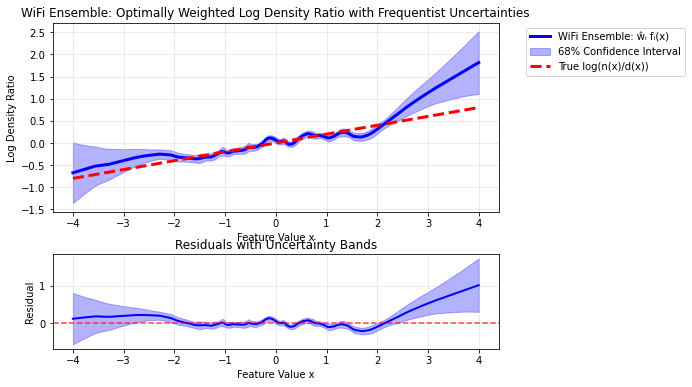

In [28]:
# Create test points for visualization of the learned density ratio
x_test = torch.linspace(-4, 4, 200).unsqueeze(1).to(device)

# Get predictions from wifi ensemble
model.eval()
with torch.no_grad():
    all_predictions = model.forward_all_members(x_test)  # [200, num_members + 1]
    
    # Compute optimally weighted ensemble output:
    optimized_output = all_predictions @ optimal_weights
    
    # Compute pointwise uncertainties using covariance matrix of weights
    pointwise_variance = torch.zeros(len(x_test), device=device)
    for i in range(len(x_test)):
        f_i = all_predictions[i]
        # Uncertainty: f(x)ᵀ Σ f(x) where Σ is covariance matrix of weights
        pointwise_variance[i] = f_i.double() @ covariance_matrix.double() @ f_i.double()

    pointwise_std = torch.sqrt(pointwise_variance)
    
    # Compute the true log density ratio (analytical solution for Gaussians)
    # For N(μₚ, σ²) vs N(μₒ, σ²): log(r(x)) = (μₚ - μₒ)/σ² * x + (μₒ² - μₚ²)/(2σ²)
    mu_signal, mu_background, sigma = 0.1, -0.1, 1.0
    true_log_ratio = ((mu_signal - mu_background) * x_test.cpu().squeeze() / sigma**2 + 
                     (mu_background**2 - mu_signal**2) / (2 * sigma**2))

# Plot the results
plt.figure(figsize=(8, 6))

# Create subplot layout
gs = plt.GridSpec(2, 1, height_ratios=[2, 1], 
                  hspace=0.3)

# Main plot: density ratio with uncertainties
ax_main = plt.subplot(gs[0])

# Plot optimally weighted WiFi ensemble: ŵᵢ fᵢ(x)
optimized_cpu = optimized_output.cpu()
uncertainty_cpu = pointwise_std.cpu()

ax_main.plot(x_test.cpu().squeeze(), optimized_cpu, 
            'blue', linewidth=3, label='WiFi Ensemble: ŵᵢ fᵢ(x)')

# Add 68% confidence intervals (±1σ)
ax_main.fill_between(x_test.cpu().squeeze(), 
                    optimized_cpu - uncertainty_cpu, 
                    optimized_cpu + uncertainty_cpu, 
                    alpha=0.3, color='blue', label='68% Confidence Interval')

# Plot true analytical solution
ax_main.plot(x_test.cpu().squeeze(), true_log_ratio, 
            'red', linestyle='--', linewidth=3, label='True log(n(x)/d(x))')

ax_main.set_xlabel('Feature Value x')
ax_main.set_ylabel('Log Density Ratio')
ax_main.set_title('WiFi Ensemble: Optimally Weighted Log Density Ratio with Frequentist Uncertainties')
ax_main.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax_main.grid(True, alpha=0.3)

# Residuals plot
ax_residual = plt.subplot(gs[1])
residuals = optimized_cpu - true_log_ratio
ax_residual.plot(x_test.cpu().squeeze(), residuals, 'blue', linewidth=2, label='WiFi - True')
ax_residual.fill_between(x_test.cpu().squeeze(), 
                        residuals - uncertainty_cpu, 
                        residuals + uncertainty_cpu, 
                        alpha=0.3, color='blue')
ax_residual.axhline(0, color='red', linestyle='--', alpha=0.7)
ax_residual.set_xlabel('Feature Value x')
ax_residual.set_ylabel('Residual')
ax_residual.set_title('Residuals with Uncertainty Bands')
ax_residual.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Mixture Fraction Estimation with Gong-Samaniego Uncertainty Propagation

Now we demonstrate a simulation-based inference application: estimating mixture fractions with proper frequentist uncertainties via the Gong-Samaniego theorem. The below cell takes two and a half minutes to run on my laptop. The first panel shows results from one inference for each value of $\kappa$ in $\{0.01, 0.02, 0.05, 0.1, 0.2, 0.5\}$, and the second panel shows the average $1 \sigma$ coverage over many inferences for $\kappa = 0.1$.

WiFi Ensemble Mixture Fraction Estimation with Coverage Validation
True $\kappa$ | Estimated $\kappa$̂ | GS Uncertainty | MLE Uncertainty | Z-score (GS)
--------------------------------------------------------------------------------


/var/folders/ww/3sjztwms3yxdfdh5qx5sy8pc0000gn/T/ipykernel_99449/663222265.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  optimal_weights = torch.tensor(result.x, dtype=torch.float32, device=device)


 0.01  |   -0.0115    |    0.1067     |    0.0631     |   0.20
 0.02  |   0.0926    |    0.0963     |    0.0665     |   0.75
 0.05  |   0.1359    |    0.1051     |    0.0713     |   0.82
 0.10  |   0.1917    |    0.0985     |    0.0677     |   0.93
 0.20  |   0.1656    |    0.0963     |    0.0683     |   0.36
 0.50  |   0.4835    |    0.0906     |    0.0712     |   0.18
Testing coverage with 100 trials (refitting weights each time)...


/var/folders/ww/3sjztwms3yxdfdh5qx5sy8pc0000gn/T/ipykernel_99449/663222265.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  optimal_weights = torch.tensor(result.x, dtype=torch.float32, device=device)


True fraction 0.1 Estimated fraction: 0.010175598636899529 GS uncertainty: 0.11080891892441203 MLE uncertainty: 0.07361778753346786
True fraction 0.1 Estimated fraction: 0.06843474288249456 GS uncertainty: 0.10987353021125895 MLE uncertainty: 0.07465229987906623
True fraction 0.1 Estimated fraction: 0.20991280418962213 GS uncertainty: 0.08843127826283274 MLE uncertainty: 0.06522321359664497
True fraction 0.1 Estimated fraction: 0.2156945101091459 GS uncertainty: 0.07914563951619083 MLE uncertainty: 0.05721801541297795
  Progress: 5/100 trials completed
True fraction 0.1 Estimated fraction: 0.1845284955462259 GS uncertainty: 0.08529595713738868 MLE uncertainty: 0.06138171719946482
True fraction 0.1 Estimated fraction: -0.0040307728722543896 GS uncertainty: 0.11736688871988991 MLE uncertainty: 0.07444868941964307
True fraction 0.1 Estimated fraction: 0.06938441674684401 GS uncertainty: 0.08804642079198265 MLE uncertainty: 0.060713859219916184
True fraction 0.1 Estimated fraction: 0.21268

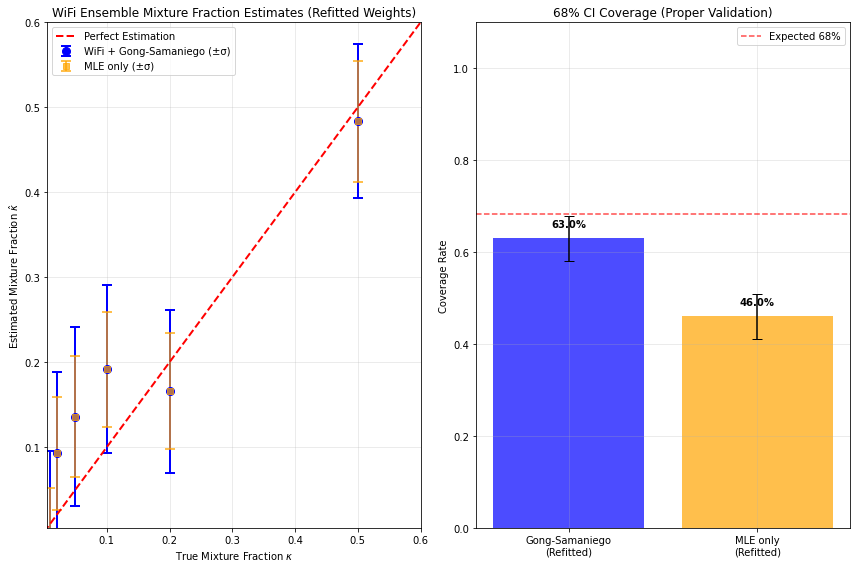


WIFI ENSEMBLE WITH PROPER COVERAGE VALIDATION - FINAL SUMMARY
Point Estimation Performance:
  Mean Absolute Error: 0.0538
  Root Mean Square Error: 0.0619

Uncertainty Quality:
  Mean Gong-Samaniego uncertainty: 0.0989
  Mean MLE uncertainty: 0.0680
  Uncertainty inflation factor: 1.45x

Frequentist Coverage (68% CI) - PROPER VALIDATION:
  Gong-Samaniego method: 63.0%
  MLE-only method: 46.0%
  Expected coverage: 68%


In [29]:
def estimate_mixture_fraction_with_gong_samaniego_uncertainties(model, mixture_data, weights, covariance_matrix):
    """
    Estimate mixture fraction with proper frequentist uncertainties using Gong-Samaniego theorem.
    
    This implements Eq. (37) from the paper:
    σ²_GS = σ²_MLE * (1 + σ²_MLE * A_i * C_ij * A_j)
    
    where:
    - σ²_MLE: Standard MLE Fisher information uncertainty  
    - A_i: Mixed derivatives ∂²log ℓ / ∂θ ∂w_i
    - C_ij: Covariance matrix of ensemble weights ŵ_i
    """
    model.eval()
    
    with torch.no_grad():
        # Get ensemble predictions for mixture data
        all_outputs = model.forward_all_members(mixture_data.to(device))  # [N, M+1]
        
        # Compute weighted ensemble output: ŵᵢ fᵢ(x)
        ensemble_output = all_outputs @ weights

    def negative_log_likelihood(kappa):
        """Negative log-likelihood for mixture fraction $\kappa$."""        
        # Likelihood: L($\kappa$) = Σ log($\kappa$ * exp(r(x_i)) + (1-$\kappa$))
        r = ensemble_output.cpu()
        # r_clamped = torch.clamp(r, min=-10, max=10)
        exp_r = torch.exp(r)
        
        log_likelihood = torch.log(kappa * exp_r + (1 - kappa)).sum()
        return -log_likelihood.item()

    # Find MLE estimate $\kappa$̂
    result = minimize_scalar(negative_log_likelihood, bounds=(-1, 2), method='bounded') # Bounds very far from fit range to avoid truncating fit
    kappa_hat = result.x
    
    # Compute standard MLE uncertainty (Fisher information)
    r = ensemble_output.cpu()
    # r_clamped = torch.clamp(r, min=-10, max=10)
    exp_r = torch.exp(r)
    
    # Fisher information for $\kappa$: I($\kappa$) = -∂²ℓ/∂$\kappa$²
    fisher_kappa = (((exp_r - 1)/(kappa_hat*exp_r + (1-kappa_hat)))**2).sum().item()
    
    sigma_mle_squared = 1.0 / fisher_kappa
    
    # Compute mixed derivatives A_i
    
    mixed_derivatives = torch.zeros(len(weights), device=device)
    for i in range(len(weights)):
        f_i = all_outputs[:, i]
        mixed_derivatives[i] = (f_i*exp_r/(kappa_hat*exp_r + (1 - kappa_hat))**2).sum()

    # Apply Gong-Samaniego theorem: σ²_GS = σ²_MLE * (1 + σ²_MLE * A_i * C_ij * A_j)
    A = mixed_derivatives.double()
    C = covariance_matrix.double()
    
    # Compute the correction term: A_i * C_ij * A_j
    correction_term = (A @ C @ A).item()
    gong_samaniego_variance = sigma_mle_squared * (1 + sigma_mle_squared * correction_term)
    
    gong_samaniego_uncertainty = np.sqrt(gong_samaniego_variance)
    
    return kappa_hat, gong_samaniego_uncertainty, sigma_mle_squared**0.5, ensemble_output.cpu()

def estimate_with_refitted_weights(model, mixture_data, X_signal_train, X_background_train):
    """
    Estimate mixture fraction with weights refitted for this specific trial.
    This provides proper coverage validation by refitting weights each time.
    """
    # Refit weights for this specific trial
    trial_weights, trial_signal_outputs, trial_background_outputs = optimize_ensemble_weights(
        model, X_signal_train, X_background_train
    )
    
    # Compute covariance matrix for these weights
    trial_covariance = compute_asymptotic_covariance_matrix(
        trial_weights, trial_signal_outputs, trial_background_outputs
    )
    
    # Estimate mixture fraction with these trial-specific weights
    return estimate_mixture_fraction_with_gong_samaniego_uncertainties(
        model, mixture_data, trial_weights, trial_covariance
    )

# Test WiFi ensemble mixture fraction estimation with coverage validation
true_fractions = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
estimated_fractions = []
gs_uncertainties = []
mle_uncertainties = []

print("WiFi Ensemble Mixture Fraction Estimation with Coverage Validation")
print("="*80)
print("True $\kappa$ | Estimated $\kappa$̂ | GS Uncertainty | MLE Uncertainty | Z-score (GS)")
print("-"*80)

for true_frac in true_fractions:
    # Generate test mixture with known fraction
    mixture_data = generate_mixture(num_test_samples, true_frac)
    
    # Estimate with refitted weights for proper coverage validation
    estimated_frac, gs_uncertainty, mle_uncertainty, _ = estimate_with_refitted_weights(
        model, mixture_data, X_signal_train, X_background_train
    )
    
    estimated_fractions.append(estimated_frac)
    gs_uncertainties.append(gs_uncertainty)
    mle_uncertainties.append(mle_uncertainty)
    
    # Compute z-score using Gong-Samaniego uncertainty
    z_score_gs = abs(true_frac - estimated_frac) / gs_uncertainty
    
    print(f" {true_frac:.2f}  |   {estimated_frac:.4f}    |    {gs_uncertainty:.4f}     |    {mle_uncertainty:.4f}     |   {z_score_gs:.2f}")

print("="*80)

# Create comprehensive visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Plot 1: Estimates with error bars
ax1.errorbar(true_fractions, estimated_fractions, yerr=[u for u in gs_uncertainties], 
             fmt='o', capsize=5, capthick=2, elinewidth=2, markersize=8, 
             color='blue', label='WiFi + Gong-Samaniego (±σ)')

ax1.errorbar(true_fractions, estimated_fractions, yerr=[u for u in mle_uncertainties], 
             fmt='s', capsize=5, capthick=2, elinewidth=2, markersize=6, alpha=0.7,
             color='orange', label='MLE only (±σ)')

ax1.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Estimation')
ax1.set_xlabel('True Mixture Fraction $\kappa$')
ax1.set_ylabel('Estimated Mixture Fraction $\kappa$̂')
ax1.set_title('WiFi Ensemble Mixture Fraction Estimates (Refitted Weights)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0.005, 0.6)
ax1.set_ylim(0.005, 0.6)

# Plot 4: Coverage analysis with refitted weights
def test_coverage_with_refitted_weights(n_tests=100):
    """Test coverage properties with refitted weights for each trial (proper validation)."""
    coverage_gs = []
    coverage_mle = []
    
    test_fractions = np.ones(n_tests)*0.1
    
    print(f"Testing coverage with {n_tests} trials (refitting weights each time)...")
    
    for i, true_frac in enumerate(test_fractions):
        X_train, y_train = generate_data(num_train_samples)
        signal_mask = y_train == 1
        background_mask = y_train == 0

        X_signal_train = X_train[signal_mask]
        X_background_train = X_train[background_mask]
        if (i + 1) % 5 == 0:
            print(f"  Progress: {i + 1}/{n_tests} trials completed")
            
        mixture_data = generate_mixture(num_test_samples, true_frac)
        estimated_frac, gs_unc, mle_unc, _ = estimate_with_refitted_weights(
            model, mixture_data, X_signal_train, X_background_train
        )
        print("True fraction", true_frac, "Estimated fraction:", estimated_frac,
              "GS uncertainty:", gs_unc,
              "MLE uncertainty:", mle_unc)
        
        # Check if true value is within 1σ
        within_gs = abs(true_frac - estimated_frac) <= gs_unc
        within_mle = abs(true_frac - estimated_frac) <= mle_unc
        
        coverage_gs.append(within_gs)
        coverage_mle.append(within_mle)
    
    return np.mean(coverage_gs), np.mean(coverage_mle)

coverage_rate_gs, coverage_rate_mle = test_coverage_with_refitted_weights()

# Coverage comparison
methods = ['Gong-Samaniego\n(Refitted)', 'MLE only\n(Refitted)']
coverage_rates = [coverage_rate_gs, coverage_rate_mle]
colors = ['blue', 'orange']

# Calculate binomial proportion error bars: sqrt(p(1-p)/n_tests)
n_tests = 100
error_bars = [np.sqrt(p * (1 - p) / n_tests) for p in coverage_rates]

bars = ax2.bar(methods, coverage_rates, yerr=error_bars, color=colors, alpha=0.7, 
               capsize=5)
ax2.axhline(y=0.683, color='red', linestyle='--', alpha=0.7, label='Expected 68%')
ax2.set_ylabel('Coverage Rate')
ax2.set_title('68% CI Coverage (Proper Validation)')
ax2.set_ylim(0, 1.1)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add percentage labels on bars
for bar, rate in zip(bars, coverage_rates):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02, 
             f'{rate:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print comprehensive summary
print("\n" + "="*80)
print("WIFI ENSEMBLE WITH PROPER COVERAGE VALIDATION - FINAL SUMMARY")
print("="*80)

# Performance metrics
errors = np.array(estimated_fractions) - np.array(true_fractions)
z_scores_gs = np.abs(errors) / np.array(gs_uncertainties)
z_scores_mle = np.abs(errors) / np.array(mle_uncertainties)

mae = np.mean(np.abs(errors))
rmse = np.sqrt(np.mean(errors**2))

print(f"Point Estimation Performance:")
print(f"  Mean Absolute Error: {mae:.4f}")
print(f"  Root Mean Square Error: {rmse:.4f}")

print(f"\nUncertainty Quality:")
print(f"  Mean Gong-Samaniego uncertainty: {np.mean(gs_uncertainties):.4f}")
print(f"  Mean MLE uncertainty: {np.mean(mle_uncertainties):.4f}")
print(f"  Uncertainty inflation factor: {np.mean(gs_uncertainties)/np.mean(mle_uncertainties):.2f}x")

print(f"\nFrequentist Coverage (68% CI) - PROPER VALIDATION:")
print(f"  Gong-Samaniego method: {coverage_rate_gs:.1%}")
print(f"  MLE-only method: {coverage_rate_mle:.1%}")
print(f"  Expected coverage: 68%")
print("="*80)